**Heart Failure Predictor**
<br> By: Xinya Lu, Leo Tang, Cheng Zhang, Eric Zhang

Heart failure is a recurring condition where the heart muscles cannot pump enough blood to different parts of the body. When heart failure occurs, the heart pumps less blood and the organs in one’s body start to malfunction, which can lead to death. Factors that can increase the chance of death include:

<u>Age</u>: Time of life in years.
<br><u>Creatine phosphokinase (CPK)</u>:  An enzyme in the body (mcg/L).
<br><u>Platelets</u>: Cell fragments in blood (platelets/mL).
<br><u>Serum creatinine</u>: Level of serum creatinine in the blood(mg/dL). 
<br><u>Serum sodium</u>: Level of serum sodium in the blood(mEq/L). 
<br><u>Ejection fraction</u>: Percentage of blood leaving the heart each contraction. 
<br><u>Smoking</u> : If they are smoking or not.

We will build a model using "https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records " to predict if a person we describe will survive a heart attack. This dataset includes observations of 299 patients, including the above factors and more, and if they survived heart failure. Through KNN classification, we will answer:

**Will a smoking 60 year old male with an ejection fraction of 40%survive heart failure?**


In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

In [3]:
##heart_failure_data <- read_csv("heart_failure_clinical_records_dataset.csv", col_types="ddddddddddddc") 
##head(heart_failure_data)

heart_failure_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv", col_types="ddddddddddddc") 
    head(heart_failure_data)

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
50,1,111,0,20,0,210000,1.9,137,1,0,7,1
65,1,160,1,20,0,327000,2.7,116,0,0,8,1
90,1,47,0,40,1,204000,2.1,132,1,1,8,1


**Tidy/wrangled data**

In [4]:
heart_split <- initial_split(heart_failure_data, prop=0.75, strata=DEATH_EVENT)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [5]:
heart_failure <- select(heart_train, age, serum_creatinine, serum_sodium,
                        creatinine_phosphokinase, platelets, ejection_fraction, smoking, DEATH_EVENT)
names(heart_failure) <- c('age','serum_creatinine','serum_sodium','creatinine_phosphokinase','platelets','ejection_fraction', 'smoking', 'death') 
head(heart_failure)

age,serum_creatinine,serum_sodium,creatinine_phosphokinase,platelets,ejection_fraction,smoking,death
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
75,1.9,130,582,265000,20,0,1
55,1.1,136,7861,263358,38,0,1
65,1.3,129,146,162000,20,1,1
50,1.9,137,111,210000,20,0,1
90,2.1,132,47,204000,40,1,1
75,1.2,137,246,127000,15,0,1


**Summary of Our Data**

In [6]:
missing_data <- heart_failure %>%
        filter(is.na(age),is.na(creatinine_phosphokinase), is.na(platelets), is.na(serum_creatinine), is.na(serum_sodium), 
               is.na(ejection_fraction)) %>%
        nrow()
heart_failure_summary <- heart_failure %>% 
                      summarize(n_observations = nrow(heart_failure),
                      average_age = mean(age, na.rm = TRUE),
                      average_creatinine_phosphokinase = mean(creatinine_phosphokinase, na.rm = TRUE),
                      average_platelets = mean(platelets, na.rm = TRUE),
                      average_serum_creatinine = mean(serum_creatinine, na.rm=TRUE),
                      average_serum_sodium = mean(serum_sodium, na.rm=TRUE),
                      average_ejection_fraction = mean(ejection_fraction, na.rm=TRUE), 
                      missing_data_rows = missing_data)
heart_failure_summary

n_observations,average_age,average_creatinine_phosphokinase,average_platelets,average_serum_creatinine,average_serum_sodium,average_ejection_fraction,missing_data_rows
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
225,60.9526,636.6578,261716.7,1.346133,136.3467,38.28444,0


**Visualizing data**

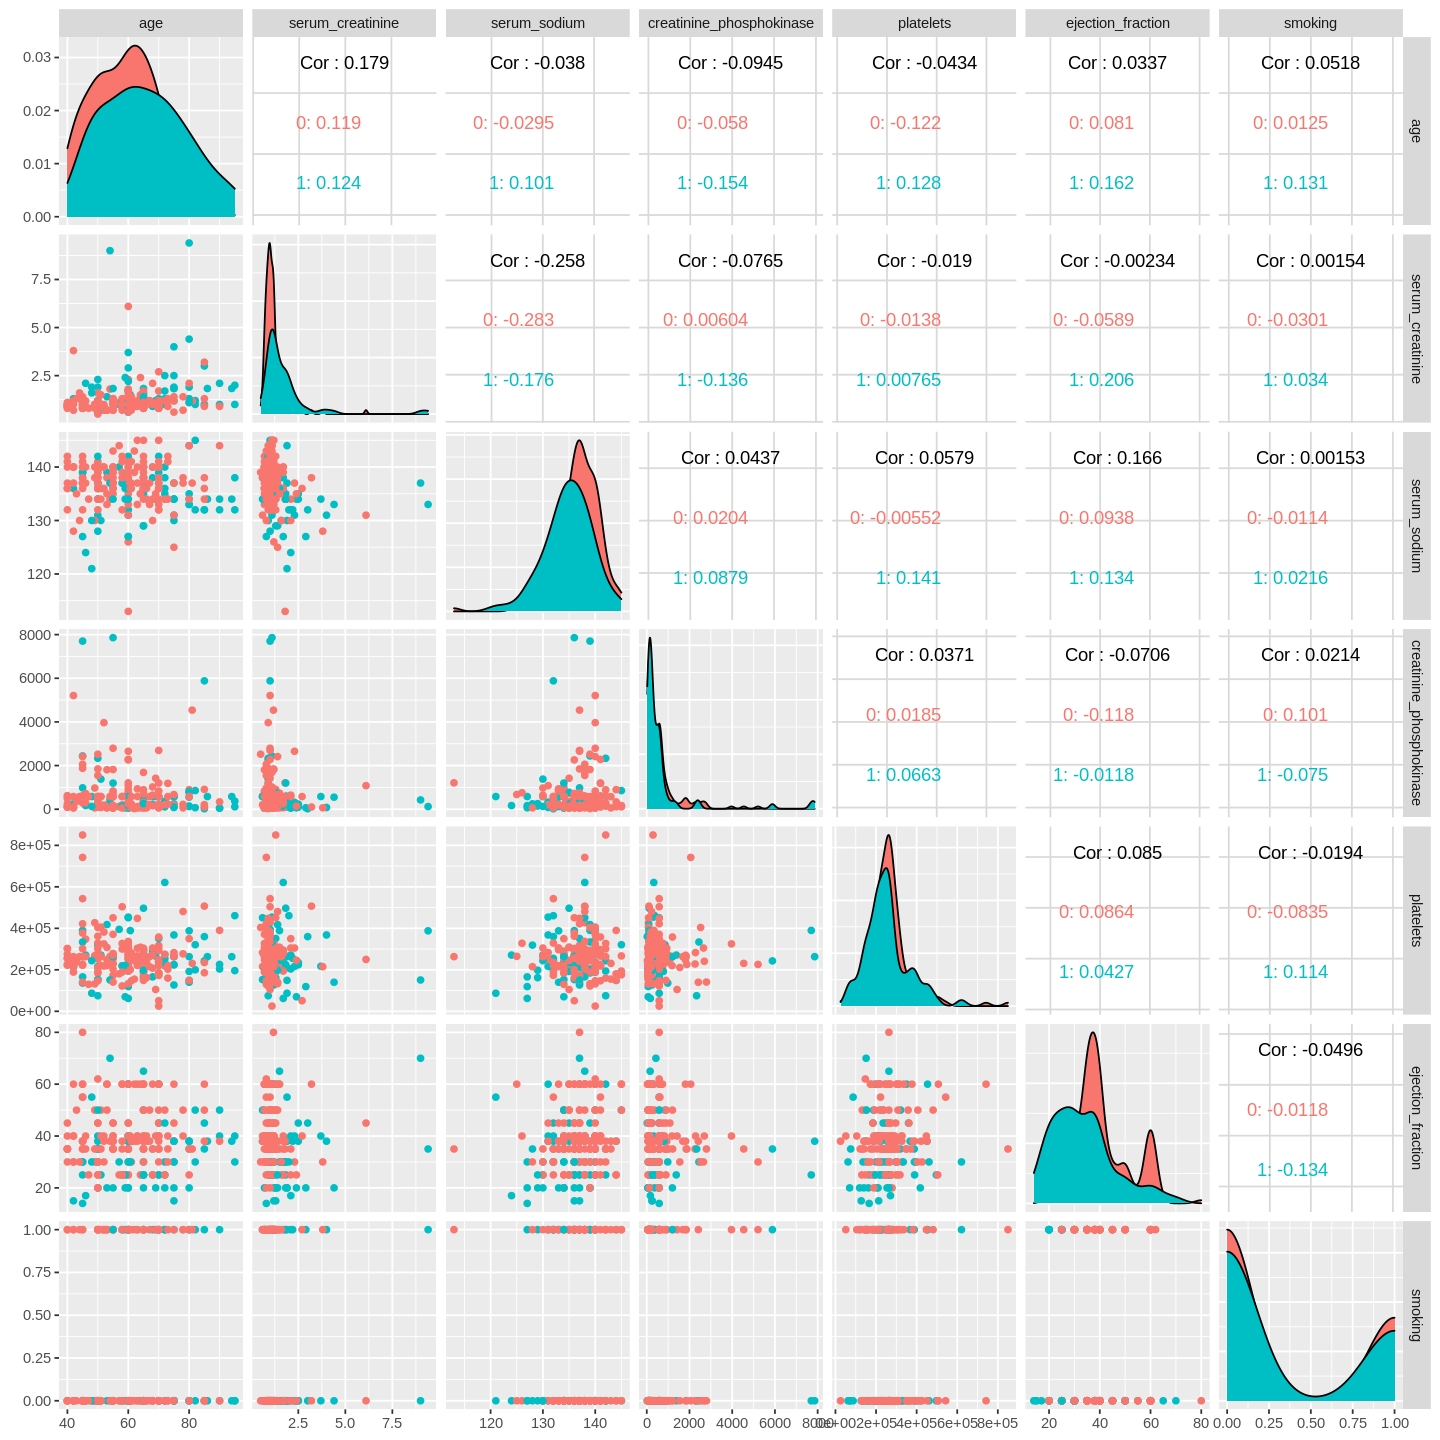

In [12]:
options(repr.plot.width = 12, repr.plot.height = 12)
heart_failure_plot1 <- ggpairs(heart_failure, columns=1:7, mapping=ggplot2::aes(colour=death)) 
heart_failure_plot1

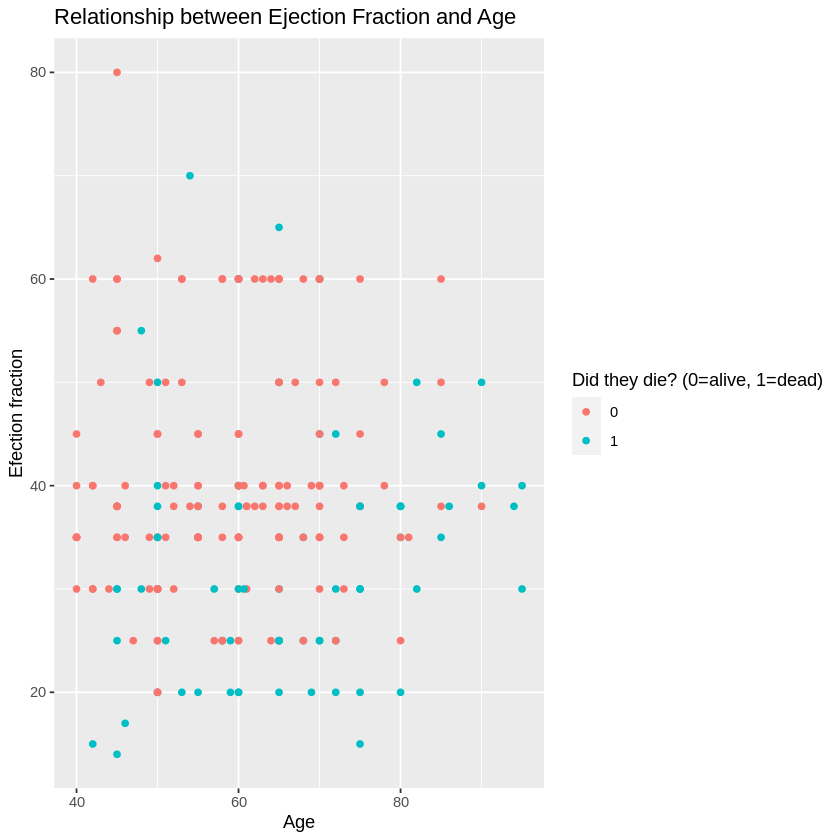

In [8]:
heart_failure_plot2 <- ggplot(heart_failure, aes(x = age, y = ejection_fraction, color = death)) +
    geom_point() +
    xlab("Age") +
    ylab("Efection fraction") +
    labs(color = "Did they die? (0=alive, 1=dead)") +
    ggtitle("Relationship between Ejection Fraction and Age")
heart_failure_plot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



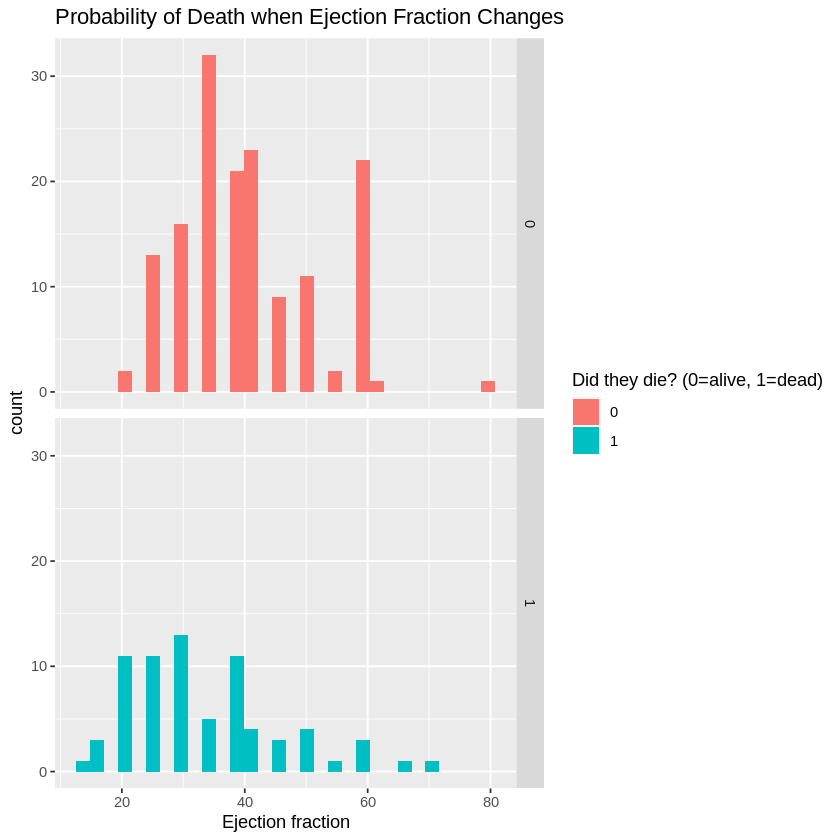

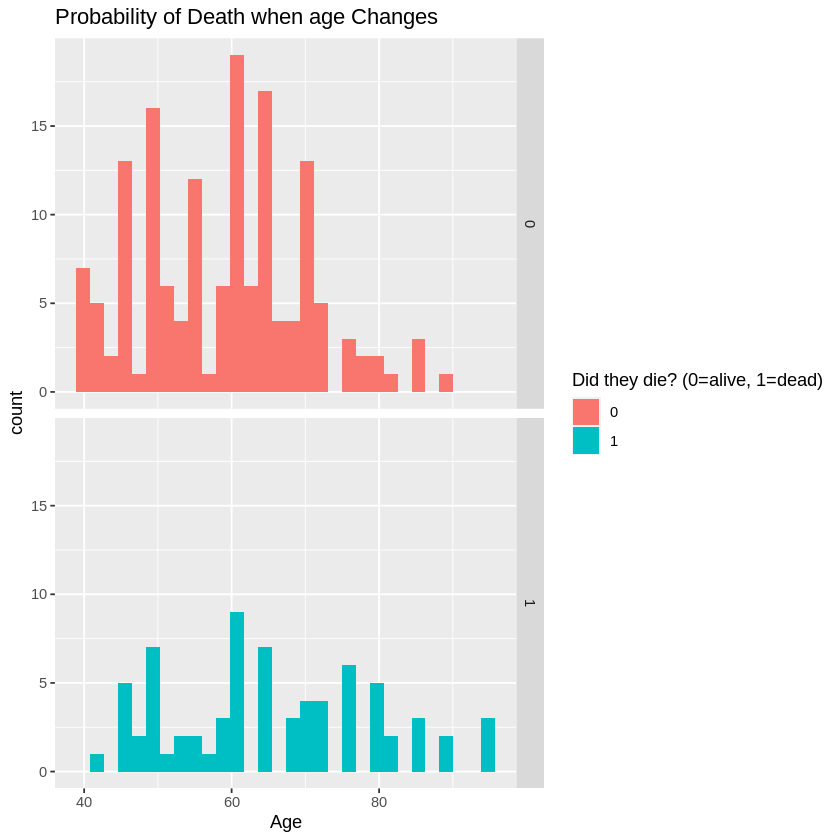

In [9]:
heart_failure_plot_ejection <- ggplot(heart_failure, aes(x = ejection_fraction, fill = death)) +
    geom_histogram(position="identity") +
    xlab("Ejection fraction") +
    labs(fill = "Did they die? (0=alive, 1=dead)") +
    ggtitle("Probability of Death when Ejection Fraction Changes")+
    facet_grid(death~.)
heart_failure_plot_ejection


heart_failure_plot_age <- ggplot(heart_failure, aes(x = age, fill = death)) +
    geom_histogram(position="identity") +
    xlab("Age") +
    labs(fill = "Did they die? (0=alive, 1=dead)") +
    ggtitle("Probability of Death when age Changes")+
    facet_grid(death~.)
heart_failure_plot_age

**Method**

We will be using the predictors age and ejection fraction for our predictors. We chose age because it can cause one’s blood vessels and heart to change negatively. For example, the heart tends to pump blood at a slower rate during physical activity. We chose the ejection fraction next because a lower percentage indicates organs might not get enough blood, which would lead to death. Our ggpair plot shows that age and ejection fraction has the least overlap between people who are dead and alive; hence, the plots show that these 2 variables are good predictors as well. Additionally, the plot of the relationship between the two variables display that people with low ejection fraction or high age are more likely to die.

Using the 2 predictors, we will create a model to see if an individual will survive heart failure. Our model will use KNN classification, where we interpret relationships between each column while colouring the points where death occured. This relationship will help determine a threshold where death is most likely. Putting an observation of a person into this model will help us predict if that person will die from heart failure. We can visualize it by putting our data point on to a scatterplot with our predictors as the axis, categorize each datapoint if they are dead or not, and see if they are within the thresholds that would predict them to be dead. 


**Expected outcomes and significance**

Using the method above, the graph of the variables will show a fitted plot such that the position of the point on the graph will help understand whether death is likely after heart failure. Understanding the relationship above allows for the outcome of heart failure to be predicted, which can help doctors make decisions (like when deciding who to save if there is a shortage of equipment available), or help persuade patients to change their life choices so that they could change what the predictor forecasted.

<u>Future Questions:</u>
<br>Based on the model, what can we advise patients to do to increase their chances of surviving heart failure?
<br>Is this model reliable enough to help doctors with decisions?
